In [ ]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [ ]:
import liana as li

In [ ]:
from matplotlib.pyplot import hist

In [ ]:
counts = pd.read_csv("data/counts_mat.csv")
weights = pd.read_csv("data/weight_mat.csv")

In [ ]:
var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
var.index.name = None

In [ ]:
adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)

In [ ]:
adata.obsm['proximity'] = csr_matrix(weights)

In [ ]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [ ]:
adata.write_h5ad("test_spatial.h5ad")

In [ ]:
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [ ]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

In [ ]:
lr_res

Correlations

In [756]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [757]:
x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [758]:
from scipy.stats import spearmanr, pearsonr, pointbiserialr, kendalltau

In [759]:
pearsonr(x, y)

(0.12061560721706954, 0.05206512033238492)

One by One

In [1043]:
def wcor(x, y, weight):
    weight_sum = np.sum(weight)
    
    numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
    denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
    denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2
    
    wcor = numerator / np.sqrt(denominator_x * denominator_y)
    
    return wcor

In [1044]:
adata.obsm['proximity']

<260x260 sparse matrix of type '<class 'numpy.float64'>'
	with 3120 stored elements in Compressed Sparse Row format>

In [ ]:
i = 0

In [1049]:
# all weights = 1 (i.e. pearsonr)
wcor(x, y, np.repeat(1, x.shape[0]))

-0.0013296463642543616

In [1078]:
weight = adata.obsm['proximity']

In [1079]:
# calculate all local correlations
# technically, if we take i (a spot), x and y (e.g. genes),
# we go over all rows in w (i.e. every spot)
# and we re-calculate PC with the spatial weights 
# for the spots i to any other spot (j)
local_corrs = []
for i in range(weight.shape[0]):
    local_corrs.append(wcor(x, y, weight[i, :].A))
local_corrs = np.array(local_corrs)

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677481, -0.45093227, -0.31508972, -0.17924717, -0.04340463,
         0.09243792,  0.22828047,  0.36412302,  0.49996556,  0.63580811,
         0.77165066]),
 <BarContainer object of 10 artists>)

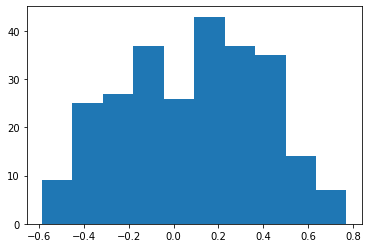

In [1080]:
hist(local_corrs)

In [1081]:
local_corrs[0:5]

array([-0.00132965,  0.17837803, -0.0006992 ,  0.0007183 , -0.21403439])

masked

In [1082]:
weight = adata.obsm['proximity'].A

In [1083]:
# msk = np.isnan(weight)
msk = np.logical_not(weight>0).astype(np.int16)

In [1084]:
weight = np.ma.masked_array(weight, mask=msk)

In [1085]:
xy_n = len(x)

In [1086]:
x_ma = np.reshape(np.repeat(x, xy_n), newshape=(xy_n, xy_n))
y_ma = np.reshape(np.repeat(y, xy_n), newshape=(xy_n, xy_n))

x_ma = np.ma.masked_array(x_ma, mask=msk, fill_value=np.nan).T
y_ma = np.ma.masked_array(y_ma, mask=msk, fill_value=np.nan).T

In [1088]:
local_corrs = []
for i in range(weight.shape[0]):
    local_corrs.append(wcor(x_ma[i, :], y_ma[i, :], weight[i, :]))
local_corrs = np.array(local_corrs)

(array([ 3., 15., 23., 30., 32., 42., 44., 31., 27., 13.]),
 array([-0.58677481, -0.43853581, -0.29029681, -0.14205781,  0.0061812 ,
         0.1544202 ,  0.3026592 ,  0.4508982 ,  0.59913721,  0.74737621,
         0.89561521]),
 <BarContainer object of 10 artists>)

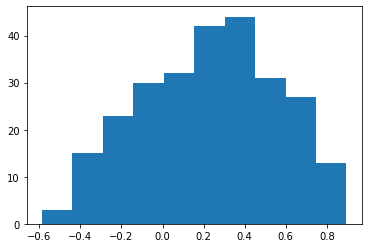

In [1090]:
hist(local_corrs)

In [ ]:
weight = weight[0, :].A

In [ ]:
weight_sum = np.sum(weight)

numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2

# wcov
numerator / np.sqrt(denominator_x * denominator_y)

In [ ]:
numerator

In [ ]:
denominator_x

In [ ]:
denominator_y

In [ ]:
weight_sum * np.sum(weight * x * y)

In [ ]:
np.sum(weight * x) * np.sum(weight * y)

In [ ]:
(weight * x)[0][0:5]

Vectorize

For one interaction at a time:

In [994]:
x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [960]:
weight = adata.obsm["proximity"].A ## does it really need to be A?

In [961]:
weight_sum = np.sum(weight, axis = 1).flatten()

In [962]:
n1 = (weight_sum * np.sum(np.multiply(weight, x) * y, axis=1))
n1[0:5]

array([413.32909519, 367.77565144, 384.96345094, 311.83233116,
       291.88845544])

In [440]:
n2 = np.sum(np.multiply(weight, x), axis=1) * np.sum(np.multiply(weight, y), axis=1)
n2[0:5]

array([413.34951981, 364.04993142, 384.97718615, 311.80720578,
       300.28635934])

In [441]:
numerator = n1 - n2

In [442]:
numerator[0:5]

array([-0.02042462,  3.72572002, -0.01373521,  0.02512538, -8.3979039 ])

In [443]:
denominator_x = weight_sum * np.sum(np.multiply(weight, (x**2)), axis = 1) - np.sum(np.multiply(weight,  x), axis=1)**2
denominator_y = weight_sum * np.sum(np.multiply(weight, (y**2)), axis = 1) - np.sum(np.multiply(weight,  y), axis=1)**2

In [444]:
denominator_x.shape

(260,)

In [445]:
denominator_x[0:5]

array([27.10800422, 25.21338601, 29.18442814, 27.59649804, 26.70265811])

In [446]:
denominator_y[0:5]

array([ 8.70438613, 17.30240674, 13.22245209, 44.33641497, 57.65276927])

In [447]:
local_corrs = numerator / np.sqrt(denominator_x * denominator_y)

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677481, -0.45093227, -0.31508972, -0.17924717, -0.04340463,
         0.09243792,  0.22828047,  0.36412302,  0.49996556,  0.63580811,
         0.77165066]),
 <BarContainer object of 10 artists>)

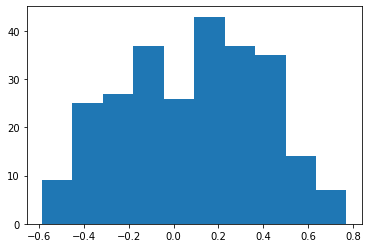

In [448]:
hist(local_corrs)

In [1040]:
def _calculate_local_correlations(x, y, weight):
    weight_sum = np.sum(weight, axis = 1).flatten()
    
    numerator = weight_sum * np.sum(np.multiply(weight, x) * y, axis=1) - np.sum(np.multiply(weight, x), axis=1) * np.sum(np.multiply(weight, y), axis=1)
    denominator_x = weight_sum * np.sum(np.multiply(weight, (x**2)), axis = 1) - np.sum(np.multiply(weight,  x), axis=1)**2
    denominator_y = weight_sum * np.sum(np.multiply(weight, (y**2)), axis = 1) - np.sum(np.multiply(weight,  y), axis=1)**2
    
    local_corrs = numerator / np.sqrt(denominator_x * denominator_y)
    
    return local_corrs

In [1007]:
x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [1042]:
_calculate_local_correlations(x, y, weight)

masked_array(data=[-0.0013296463642543616, 0.17837803274453945,
                   -0.0006992037436245069, 0.0007182991872224397,
                   -0.2140343934456279, -0.021551018358946118,
                   -0.0023898905141143444, -0.0709542255040695,
                   -0.07780877403970567, 0.20931841391807432,
                   0.02818586514187108, -0.056877721754768795,
                   0.18204359762700678, 0.34405824530618023,
                   0.3750139626215644, 0.04185427952343566,
                   0.16815623011323214, 0.6157382023493547,
                   0.30264625252291527, 0.28213808945298274,
                   0.1595449167188581, -0.08491394531201424,
                   0.312473112467803, 0.4093990352560375,
                   0.4520311504761577, 0.46146112775158005,
                   0.34980443904777797, 0.16805522369143244,
                   -0.3544333750268271, 0.1440937616898399,
                   0.10162337826080263, 0.31026940258049246,
               

In [1009]:
import scipy.stats as stats

In [1010]:
weight = adata.obsm["proximity"].A
weight_sum = np.sum(weight, axis = 1).flatten()

In [1011]:
msk = np.isnan(weight)
# msk = np.logical_not(weight>0).astype(np.int16)

In [1012]:
weight = np.ma.masked_array(weight, mask=msk)

In [1013]:
xy_n = len(x)

In [1027]:
x_ma = np.reshape(np.repeat(x, xy_n), newshape=(xy_n, xy_n))
y_ma = np.reshape(np.repeat(y, xy_n), newshape=(xy_n, xy_n))

x_ma = np.ma.masked_array(x_ma, mask=msk, fill_value=np.nan).T
y_ma = np.ma.masked_array(y_ma, mask=msk, fill_value=np.nan).T

In [1028]:
x_ma[0:5, 0:5]

masked_array(
  data=[[1.3720041513442993, 3.1812515258789062, 3.032067060470581,
         1.2108688354492188, 2.0713627338409424],
        [1.3720041513442993, 3.1812515258789062, 3.032067060470581,
         1.2108688354492188, 2.0713627338409424],
        [1.3720041513442993, 3.1812515258789062, 3.032067060470581,
         1.2108688354492188, 2.0713627338409424],
        [1.3720041513442993, 3.1812515258789062, 3.032067060470581,
         1.2108688354492188, 2.0713627338409424],
        [1.3720041513442993, 3.1812515258789062, 3.032067060470581,
         1.2108688354492188, 2.0713627338409424]],
  mask=[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],
  fill_value=nan,
  dtype=float32)

In [1029]:
# x_ma = np.ma.masked_array(stats.mstats.rankdata(x_ma, axis=0), msk)
# y_ma = np.ma.masked_array(stats.mstats.rankdata(y_ma, axis=0), msk)

In [1030]:
# vector
n1 = (((x_ma * y_ma).dot(weight.T)) * weight_sum)
n2 = (x_ma.dot(weight.T)) * (y_ma.dot(weight.T))
numerator = n1 - n2

denominator_x = (weight_sum * (x_ma ** 2).dot(weight.T)) - (x_ma.dot(weight.T))**2
denominator_y = (weight_sum * (y_ma ** 2).dot(weight.T)) - (y_ma.dot(weight.T))**2

local_corrs = (numerator / np.sqrt(denominator_x * denominator_y))


In [1026]:
numerator

masked_array(
  data=[[3.753620205770858e-06, 3.753620148927439e-06,
         3.7536201773491484e-06, ..., 3.7536201205057296e-06,
         3.753620148927439e-06, 3.753620148927439e-06],
        [1.2458526782666013e-05, 1.2458526668979175e-05,
         1.2458526839509432e-05, ..., 1.2458526725822594e-05,
         1.2458526725822594e-05, 1.2458526839509432e-05],
        [1.9075276895819115e-05, 1.907527712319279e-05,
         1.9075277066349372e-05, ..., 1.9075277009505953e-05,
         1.9075277009505953e-05, 1.9075277009505953e-05],
        ...,
        [-4.882652547166799e-06, -4.882652604010218e-06,
         -4.882652604010218e-06, ..., -4.882652604010218e-06,
         -4.882652604010218e-06, -4.882652547166799e-06],
        [-3.0245607831602683e-06, -3.0245607831602683e-06,
         -3.0245607831602683e-06, ..., -3.0245607831602683e-06,
         -3.0245607263168495e-06, -3.0245607831602683e-06],
        [-3.0252716101131227e-06, -3.0252716669565416e-06,
         -3.025271553269704e

In [1018]:
denominator_y[0:5,0]

masked_array(data=[3.7380960975497146e-06, 9.88419554914799e-06,
                   -1.61501870934444e-05, 3.6054849488209584e-06,
                   1.972582447251625e-05],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [1019]:
# one by one
weight_sum = np.sum(weight, axis = 1).flatten()

numerator = weight_sum * np.sum(np.multiply(weight, x) * y, axis=1) - np.sum(np.multiply(weight, x), axis=1) * np.sum(np.multiply(weight, y), axis=1)
denominator_x = weight_sum * np.sum(np.multiply(weight, (x**2)), axis = 1) - np.sum(np.multiply(weight,  x), axis=1)**2
denominator_y = weight_sum * np.sum(np.multiply(weight, (y**2)), axis = 1) - np.sum(np.multiply(weight,  y), axis=1)**2

local_corrs = numerator / np.sqrt(denominator_x * denominator_y)

In [1020]:
denominator_y[0:5]

masked_array(data=[8.70438613109468, 17.302406742871028,
                   13.222452090727131, 44.33641497189302,
                   57.65276927205707],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [1021]:
denominator_x.shape

(260,)

In [1023]:
local_corrs.shape

(260,)

In [809]:
local_corrs.shape

(260, 260)

In [703]:
np.max(local_corrs)

10.061205419854609

In [844]:
(x_ma.dot(weight)) * (y_ma.dot(weight))

masked_array(
  data=[[75.7497886830726, 271.62248807542704, 219.46520940319812, ...,
         136.1027212689521, 177.7668196165905, 136.10272126895214],
        [141.45279494243564, 507.21937018516695, 409.8224932691665, ...,
         254.1539805914565, 331.9562195480249, 254.1539805914566],
        [158.2514248769902, 567.4556525353737, 458.49213183012125, ...,
         284.33676113027366, 371.3786267823983, 284.33676113027377],
        ...,
        [173.7869291218481, 623.16263719971, 503.50219392477504, ...,
         312.2500324511613, 407.8367770790678, 312.25003245116136],
        [123.15534811429066, 441.6086520657751, 356.8104245955004, ...,
         221.27821487805335, 289.0164439223555, 221.27821487805343],
        [96.69241948496503, 346.71826832974574, 280.1410071089978, ...,
         173.73119643993945, 226.9142157582883, 173.73119643993948]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, F

All local corrs for all interactions

In [ ]:
ligand_mat

In [ ]:
receptor_mat

In [ ]:
weight = adata.obsm["proximity"].A.T ## does it really need to be A?

In [ ]:
weight_sums = np.sum(weight, axis = 0).flatten()

In [ ]:
x_mat = ligand_mat.A.T
y_mat = receptor_mat.A.T

In [ ]:
from scipy.stats import rankdata

In [ ]:
# x_mat = rankdata(x_mat, axis=0)
# y_mat = rankdata(y_mat, axis=0)

In [ ]:
n1 = (((x_mat * y_mat).T @ weight) * weight_sums.T)

In [ ]:
n1[0:5, 0]

In [ ]:
n2 = (x_mat.T @ weight) * (y_mat.T @ weight)

In [ ]:
numerator = n1 - n2

In [ ]:
numerator[0,0:5]

In [ ]:
denominator_x = (weight_sums * (x_mat ** 2).T @ weight) - (x_mat.T @ weight)**2
denominator_y = (weight_sums * (y_mat ** 2).T @ weight) - (y_mat.T @ weight)**2

In [ ]:
denominator_x[0, 0:5]

In [ ]:
denominator_y[0, 0:5]

In [ ]:
local_corrs = (numerator / np.sqrt(denominator_x * denominator_y)).T

In [ ]:
hist(local_corrs[:,0])

In [ ]:
local_corrs[0:5,0]

Clean

In [30]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [31]:
import liana as li

In [32]:
from matplotlib.pyplot import hist

In [33]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [34]:
from scipy.stats import rankdata

In [35]:
# toy data and toy resource
adata = sc.read_h5ad("test_spatial.h5ad")
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [36]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!
Converting mat to CSR format


In [242]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [243]:
x_mat = ligand_mat.A
y_mat = receptor_mat.A

In [244]:
dist = adata.obsm['proximity']

In [266]:
def calculate_local_correlations(x_mat, y_mat, dist, method="pearson"):
    if method not in ["pearson", "spearman", "spearman_nz"]:
        raise ValueError("method must be one of 'pearson', 'spearman', 'spearman_nz'")
    
    weight = dist.A.T ## does it really need to be A?
    weight_sums = np.sum(weight, axis = 0).flatten()
        
    if method=="spearman":
        x_mat = rankdata(x_mat, axis=1)
        y_mat = rankdata(y_mat, axis=1)
    
    # standard pearson
    n1 = (((x_mat * y_mat).dot(weight)) * weight_sums)
    n2 = (x_mat.dot(weight)) * (y_mat.dot(weight))
    numerator = n1 - n2
    
    denominator_x = (weight_sums * (x_mat ** 2).dot(weight)) - (x_mat.dot(weight))**2
    denominator_y = (weight_sums * (y_mat ** 2).dot(weight)) - (y_mat.dot(weight))**2
    
    local_corrs = (numerator / np.sqrt(denominator_x * denominator_y))
    
    return local_corrs

In [267]:
local_pc = calculate_local_correlations(x_mat, y_mat, dist, method="pearson")
local_sp = calculate_local_correlations(x_mat, y_mat, dist, method="spearman")

In [370]:
weight = dist.A.T ## does it really need to be A?

In [371]:
np.mean(x_mat.dot(weight))

15.733572500753096

In [529]:
msk = np.int16(weight==0)

In [530]:
weight2 = np.ma.masked_array(data = weight, mask=msk, fill_value=np.nan)

In [531]:
x_mat2 = np.ma.masked_array(x_mat, mask=np.isnan(x_mat))

In [532]:
x_mat.shape

(3, 260)

In [533]:
xx = np.ma.masked_array.dot(x_mat2, weight2)

In [377]:
weight2 * 2

masked_array(
  data=[[2.0, --, 1.333333333333334, ..., --, --, 1.166666666666666],
        [1.0, 2.0, 1.833333333333334, ..., --, --, 1.333333333333334],
        [1.666666666666666, 1.833333333333334, 2.0, ..., --, --,
         1.666666666666666],
        ...,
        [--, --, --, ..., 2.0, --, --],
        [--, --, --, ..., --, 2.0, --],
        [1.333333333333334, 1.166666666666666, 1.666666666666666, ...,
         --, --, 2.0]],
  mask=[[False,  True, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True, False],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [False, False, False, ...,  True,  True, False]],
  fill_value=nan)

In [378]:
np.mean(xx)

15.733572500753096

(array([ 3., 12., 20., 38., 36., 50., 36., 37., 23.,  5.]),
 array([-0.70673671, -0.57224594, -0.43775517, -0.30326441, -0.16877364,
        -0.03428288,  0.10020789,  0.23469865,  0.36918942,  0.50368018,
         0.63817095]),
 <BarContainer object of 10 artists>)

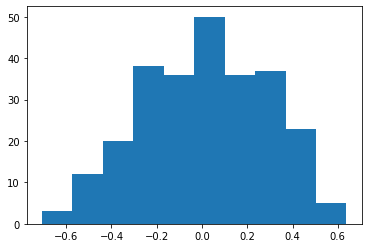

In [268]:
hist(local_spnz[0,:])

In [269]:
from scipy.stats import spearmanr, pearsonr

In [271]:
pearsonr(local_spnz[0,:], local_sp[0,:])

(1.0, 0.0)

local p-values

In [108]:
from numpy import random
from tqdm import tqdm

In [109]:
rng = random.default_rng()
n_perm = 1000
positive_only = True # remove this option?

In [110]:
local_pc.shape

(3, 260)

In [131]:
def _get_local_permutation_pvals(x_mat, y_mat, truth, function, dist, n_perm, positive_only=True, **kwargs):
    xy_n = truth.shape[0]
    spot_n = truth.shape[1]
    
    # permutation cubes to be populated
    local_pvals = np.zeros((xy_n, spot_n))
    
    # shuffle the matrix
    for i in tqdm(range(n_perm)):
        _idx = rng.permutation(spot_n)
        perm_r = function(x_mat = x_mat[:, _idx], y_mat=y_mat, dist=dist, **kwargs)
        if positive_only:
            local_pvals += np.array(perm_r >= truth, dtype=int)
        else:
            local_pvals += (np.array(np.abs(perm_r) >= np.abs(truth), dtype=int))

    local_pvals = local_pvals / n_perm
    
    return local_pvals
    

In [132]:
local_pvals = _get_local_permutation_pvals(x_mat, y_mat, local_pc, calculate_local_correlations, dist, n_perm, positive_only=True)

100%|██████████| 1000/1000 [00:00<00:00, 1839.79it/s]


In [133]:
local_pc.shape[1]

260

In [135]:
local_pvals.T

array([[0.488, 0.207, 0.006],
       [0.265, 0.098, 0.018],
       [0.471, 0.156, 0.009],
       [0.501, 0.292, 0.202],
       [0.714, 0.397, 0.591],
       [0.505, 0.111, 0.628],
       [0.526, 0.172, 0.306],
       [0.563, 0.213, 0.467],
       [0.587, 0.595, 0.341],
       [0.279, 0.183, 0.638],
       [0.464, 0.652, 0.201],
       [0.52 , 0.015, 0.739],
       [0.27 , 0.027, 0.038],
       [0.134, 0.018, 0.004],
       [0.122, 0.096, 0.01 ],
       [0.44 , 0.076, 0.402],
       [0.279, 0.005, 0.086],
       [0.034, 0.142, 0.216],
       [0.21 , 0.411, 0.506],
       [0.209, 0.24 , 0.266],
       [0.342, 0.082, 0.525],
       [0.536, 0.031, 0.465],
       [0.186, 0.749, 0.194],
       [0.149, 0.668, 0.426],
       [0.102, 0.661, 0.127],
       [0.121, 0.326, 0.316],
       [0.143, 0.427, 0.515],
       [0.283, 0.368, 0.77 ],
       [0.889, 0.346, 0.963],
       [0.324, 0.394, 0.543],
       [0.378, 0.683, 0.097],
       [0.196, 0.66 , 0.475],
       [0.379, 0.41 , 0.704],
       [0.

In [ ]:
spot_n = pc.shape[1]  # n of 1:1 edges 
xy_n = pc.shape[0] # n of x-y pairs (e.g. lrs)

# permutation cubes to be populated
local_pvals = np.zeros((xy_n, spot_n))

In [ ]:

for i in tqdm(range(n_perm)):
    _idx = rng.permutation(x_mat.shape[0])
    perm_r = calculate_local_correlations(x_mat[_idx, :], y_mat, dist)
    if positive_only:
        local_pvals += np.array(perm_r >= pc, dtype=int)
    else:
        local_pvals += (np.array(np.abs(perm_r) >= np.abs(pc), dtype=int))

local_pvals = local_pvals / n_perm

In [ ]:
local_pvals.shape